### Q1. Maximum Entropy with Moment Constraints

In [32]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

e) Solving the primal problem

In [ ]:
#Reading mu and phi from csv files
mu = pd.read_csv('mu_Q1.csv')
phi = pd.read_csv('Phi_Q1.csv')

In [39]:
mu

,Unnamed: 0,mu_1,mu_2
0,value,0.066817,0.226496


In [40]:
phi

,index,phi_1,phi_2
0,i=1,0.920486,0.060609
1,i=2,1.026894,0.723308
2,i=3,0.245642,1.058182
3,i=4,-0.422201,1.116496
4,i=5,-0.722628,0.641139
5,i=6,-0.830900,-0.095261
6,i=7,-0.795852,-0.658174
7,i=8,-0.179438,-0.716153
8,i=9,0.266855,-1.166443
9,i=10,0.865315,-0.644569


In [ ]:
#Converting mu into a numpy array
mu = np.array(mu.drop(columns = 'Unnamed: 0'),dtype=np.float32)[0]

In [42]:
mu

array([0.06681743, 0.22649647], dtype=float32)

In [ ]:
#Converting phi into a numpy array
phi = np.array(phi.drop(columns = 'index'),dtype=np.float32)

In [45]:
phi

array([[ 0.9204856 ,  0.06060879],
       [ 1.0268935 ,  0.7233076 ],
       [ 0.24564175,  1.058182  ],
       [-0.42220065,  1.1164961 ],
       [-0.72262794,  0.64113855],
       [-0.8309003 , -0.09526086],
       [-0.7958524 , -0.65817416],
       [-0.17943783, -0.7161527 ],
       [ 0.2668553 , -1.1664429 ],
       [ 0.86531466, -0.64456856]], dtype=float32)

In [444]:
#Picking initial p to start Projected Gradient Descent
def init_p():
    initial_p = np.random.random(10)
    initial_p /= np.sum(initial_p)  #Normalising it so that it is a valid probability
    return initial_p

In [445]:
#Computing objective value at the end of each iteration
def compute_objective_fn(p):
    mask = p > 0    #To enforce 0log0 = 0
    objective_val = np.sum(p[mask] * np.log(p[mask]))
    return objective_val

In [446]:
#Computing moment and simplex residuals at the end of each iteration
def compute_residuals(p):
    moment_residual = np.linalg.norm(phi.T @ p - mu, ord=2)
    simplex_residual = np.abs(p.sum() - 1.0)
    return moment_residual, simplex_residual

In [447]:
#Computing the gradient of the objective
def grad_fn(p):
    grad = 1 + np.log(np.maximum(p, 1e-12)) #For numerical stability
    return grad

In [448]:
#Projection function to project the output from gradient descent onto the constraint set
def projection_fn(y,verbose=False):
    z = cp.Variable(len(y))
    constraints = [phi.T@z == mu, cp.sum(z) == 1,z >= 0]
    objective = cp.Minimize(cp.sum_squares(z - y))
    
    problem = cp.Problem(objective,constraints)
    if verbose:
        print("problem is DCP:", problem.is_dcp())
    
    problem.solve()
    if verbose: 
        print("status:", problem.status)
        print("optimal value of objective:", problem.value)
        print("optimal value of z:", z.value)
    z_val = z.value
    z_val = np.maximum(z_val, 1e-12) #For numerical stability
    return z_val

In [449]:
#Projected Gradient Descent function for solving the convex the convex optimisation problem
def projected_gradient_descent(total_iter,step_size,verbose=False):
    objective_val_list = []
    moment_residual_list = []
    simplex_residual_list = []
    
    p = init_p()
    for iter in range(total_iter):
        grad = grad_fn(p)
        y_k = p - (step_size * grad)
        
        z = projection_fn(y_k,verbose)
        p = z
        
        objective_val_list.append(compute_objective_fn(p))
        moment_residual,simplex_residual = compute_residuals(p)
        moment_residual_list.append(moment_residual)
        simplex_residual_list.append(simplex_residual)
    
    return p, objective_val_list, moment_residual_list, simplex_residual_list

In [450]:
#Setting parameters - total iterations and step size
total_iter = 1000
step_size = 0.001

In [451]:
#Running PGD
p_star,obj_val,moment_res,simplex_res = projected_gradient_descent(total_iter,step_size)

In [452]:
#Results after running PGD
print(f"The optimiser p* is: {p_star}")
print(f"The optimal value of the primal problem H(p*): {-obj_val[-1]}")
print(f"Moment Residual: {moment_res[-1]}")
print(f"Simplex Residual: {simplex_res[-1]}")

The optimiser p* is: [0.10320789 0.12905303 0.13716353 0.13404096 0.11263167 0.0879115
 0.07328337 0.07472996 0.06631624 0.08166184]
The optimal value of the primal problem H(p*): 2.270053581991043
Moment Residual: 2.7755575615628914e-17
Simplex Residual: 1.1102230246251565e-16


 - The primal optimiser $p^*$ = [0.10320789 0.12905303 0.13716353 0.13404096 0.11263167 0.0879115
 0.07328337 0.07472996 0.06631624 0.08166184]
 - The optimal value of the primal problem $H(p^*)$ = 2.270053581991043
 - $||\Phi^Tp^* - \mu||_2$ = 2.7755575615628914e-17
 - $|\mathbb{1}^Tp^* - 1|$ = 1.1102230246251565e-16

In [453]:
#Getting list for iterations and the objective value of the concave problem
iterations = [k for k in range(len(obj_val))]
H_p = [-val for val in obj_val]

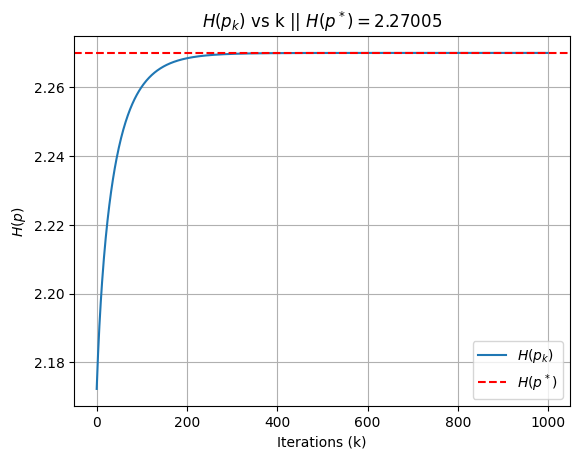

In [454]:
#Plotting H(p_k) vs k
H_star = H_p[-1]
line_color = 'red'

plt.figure()
plt.plot(iterations, H_p, label=r"$H(p_k)$")
plt.axhline(H_star, color=line_color, linestyle="--", label=r"$H(p^*)$")
plt.title(r"$H(p_k)$ vs k || $H(p^*) = %.5f$" % H_star)
plt.xlabel("Iterations (k)")
plt.ylabel(r"$H(p)$")
plt.grid(True)
plt.legend()
plt.show()


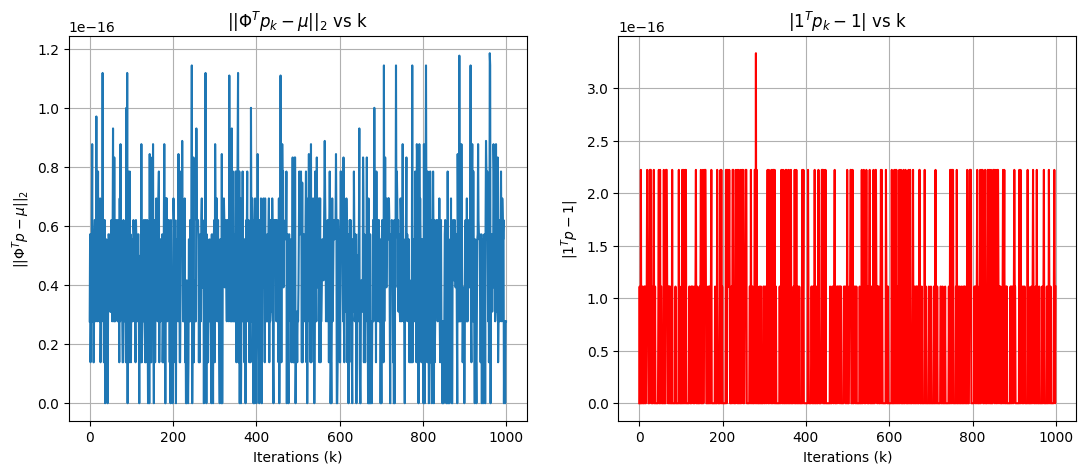

In [455]:
#Plotting residuals vs k
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.plot(iterations,moment_res)
plt.xlabel("Iterations (k)")
plt.ylabel(r"$||\Phi^Tp - \mu||_2$")
plt.title(r"$||\Phi^Tp_k - \mu||_2$ vs k")
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(iterations,simplex_res,color = "red")
plt.xlabel("Iterations (k)")
plt.ylabel(r"$|1^Tp - 1|$")
plt.title(r"$|1^Tp_k - 1|$ vs k")
plt.grid(True)

plt.show()

f) Solving the dual problem

In [425]:
#Setting up dual variables and the dual objective function
nu = cp.Variable()
theta = cp.Variable(2)
log_sum = cp.log_sum_exp(cp.hstack([theta @ phi[i] for i in range(10)]))    #Writing it in log-sum-exp form for DCP
objective = cp.Minimize(cp.exp((nu - 1) + log_sum) - theta @ mu - nu)
problem = cp.Problem(objective)

In [426]:
#Checking if the problem is DCP
print("problem is DCP:", problem.is_dcp())

problem is DCP: True


In [427]:
#Solving the dual problem
problem.solve() 
print("status:", problem.status)
print("Optimal value of objective:", problem.value)
print("Optimal value of theta: ",theta.value)
print("Optimal value of nu: ",nu.value)

status: optimal
Optimal value of objective: 2.270053588103975
Optimal value of theta:  [0.06250803 0.32724564]
Optimal value of nu:  -1.3483401003235238


- Optimal value of dual objective $d^*$ = 2.270053588103975
- $\theta^*$ = [0.06250803 0.32724564]
- $\nu^*$ = -1.3483401003235238

In [428]:
#Calculating primal optimiser using dual optimisers
theta_star = theta.value
nu_star = nu.value
normalisation_factor = np.exp(nu_star - 1)
p_tilde = (np.exp(phi@theta_star))*normalisation_factor
print(f"Optimal point p_tilde obtained from dual optimisers: {p_tilde}")

Optimal point p_tilde obtained from dual optimisers: [0.10321218 0.12906337 0.13714726 0.13407411 0.11262401 0.08790912
 0.07327968 0.07472697 0.06631277 0.08166063]


- Optimal point $\tilde{p}$ computed using $\theta^*$ and $\nu^*$ = [0.10321218 0.12906337 0.13714726 0.13407411 0.11262401 0.08790912
 0.07327968 0.07472697 0.06631277 0.08166063]

In [429]:
#Calculating difference in primal optimisers obtained using both methods
inf_norm_p = np.linalg.norm((p_star - p_tilde),np.inf)
print(f"The infinity norm of the primal optimisers is: {inf_norm_p}")

The infinity norm of the primal optimisers is: 5.689595832675254e-05


- $||p^{*} - \tilde{p}||_{\infty}$ = 5.689595832675254e-05

In [430]:
#Calculating duality gap
duality_gap = np.abs(H_star - problem.value)
print(f"The duality gap is: {duality_gap}")

The duality gap is: 1.498197832461301e-08


- Duality gap $|H(p^*) - g(\theta^*,\nu^*)|$ = 1.498197832461301e-08